**라이브러리**

In [4]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import os
#정규표현식 모듈
import re
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**데이터 준비(문장 => 단어 분할 => 벡터화)**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
SOS_token = 0
EOS_token = 0
MAX_LENGTH = 20

#딕셔너리 구성
class Lang:
  def __init__ (self):    #단어의 인덱스 저장할 컨테이너 초기화
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS"} #여기서는 SOS를 문장시작, EOS를 문장끝으로
    self.n_words = 2 #SOS와 EOS에 대한 카운트

  def addSentence(self, sentence): #문장을 단어 단위로 분리한 후 컨테이너에 추가
    for word in sentence.split(''):
      self.addWord(word)

  def addWord(self, word): #컨테이너에 단어가 없으면 추가되고, 있으면 카운트가 업데이트
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

**데이터 정규화(pandas로 불러와 정규화)**

In [7]:
def normalizeString(df, lang):
  sentence = df[lang].str.lower() #소문자로 전환
  sentence = sentence.str.replace('[ㅣ가-힣?.!,]+','') #괄호 안 제외하고 모두 공백으로 바꿈
  sentence = sentence.str.normalize('NFD') #NFD => 유니코드 정규화 방식
  sentence = sentence.str.encode('ascii', errors='ignore').str.decode('utf-8') #유니코드를 아스키코드로 전환
  return sentence

def read_sentence(df, lang1, lang2):
  sentence1 = normalizeString(df, lang1) #데이터셋의 첫번째 열(고전문학본)
  sentence2 = normalizeString(df, lang2) #데이터셋의 두번째 열(해석본)
  return sentence1, sentence2

#데이터셋 불러오기
def read_flie(loc, lang1, lang2):
  df = pd.read_csv(loc, delimiter='|', header=None, names=[lang1, lang2])
  return df

def process_data(lang1, lang2):
  df = read_flie('/content/drive/MyDrive/관동별곡.txt'% (lang1,lang2), lang1, lang2)
  sentence1, sentence2 = read_sentence(df, lang1, lang2)

#딕셔너리에 저장
  input_lang = Lang()
  output_lang = Lang()
  pairs = []
  for i in range(len(df)):
    if len(sentence1[i].split('')) < MAX_LENGTH and len(sentence2[i].split('')) < MAX_LENGTH:
      full = [sentence1[i], sentence2[i]] #첫 번째열과 두 번째 열을 합해서 저장
      input_lang.addSentence(sentence1[i]) #입력으로 고전문학 언어 사용
      output_lang.addSentence(sentence2[i]) #출력으로 해석본 언어 사용
      pairs.append(full) #pairs는 입력과 출력이 합쳐진 것 사용
    
    return input_lang, output_lang, pairs

**텐서로 변환(paris 쌍을 텐서로 변환) => pytorch는 텐서 유형의 데이터만 인식!**

In [8]:
def indexesFromSentence(lang, sentence): #문장을 단어로 분리하고 인덱스를 반환
  return [lang.word2index[word] for word in sentence.split('')] 

def tensorFromSentence(lang, sentence): #딕셔너리에서 단어에 대한 인덱스를 가져오고, 문장 끝에 토큰 추가- SOS, EOS
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(input_lang, output_lang, pair): #입력과 출력 문장을 텐서로 변환하여 반환
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return(input_tensor, target_tensor)

**인코더 네트워크(인코더 : 입력 문장을 단어별로 순서대로 인코딩을 하게 되며, 문장의 끝을 표시하는 토큰이 붙는다.**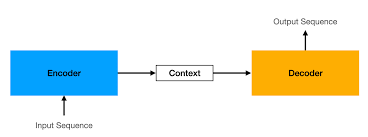

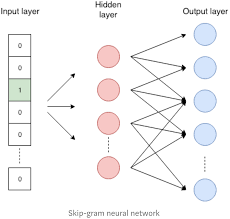

In [9]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim,embbed_dim, num_layers):
    super(Encoder, self).__init__()
    self.input_dim = input_dim #인코더에서 사용할 입력층
    self.embbed_dim = embbed_dim #인코더에서 사용할 임베딩 계층
    self.hidden_dim = hidden_dim #인코더에서 사용할 은닉층(이전 은닉층)
    self.num_layers = num_layers #인코더에서 사용할 RRU의 계층 개수
    self.embedding = nn.Embedding(input_dim, self.embbed_dim) #임베딩 계층 초기화
    self.gru = nn.GRU(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers) #임베딩 차원, 은닉층 차원, GRU의 계층 개수를 이용하여 GRU 계층을 초기화

  def forward(self, src):
    embedded = self.embedding(src).view(1, 1, -1) #임베딩 처리
    outputs, hidden = self.gru(embedded)
    return outputs, hidden


In [ ]:
def AttenDecoderRNN(nn.Module):
  def __init__(self, input_dim, hidden_dim,embbed_dim, num_layers):

**디코더 네트워크(디코더 : 인코더 출력을 디코딩하여 다음 출력을 예측함.) => 여기서부터 attention이 적용된 디코더를 구현하여 다른 코드로도 작성할 수 있음 => attention을 적용하면 긴 시퀀스의 문장을 처리할 때 정확도 향상을 가져올 수 있음. => 밑 코드에서는 attention 적용 X**

In [10]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, embbed_dim, num_layers):
      super(Decoder, self).__init()
      
      self.embbed_dim = embbed_dim
      self.hidden_dim = hidden_dim
      self.output_dim = output_dim
      self.num_layers = num_layers

      self.embedding = nn.Embedding(output_dim, self.embbed_dim) #임베딩 계층 초기화
      self.gru = nn.GRU(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers) #GRU 계층 초기화
      self.out = nn.Linear(self.hidden_dim, output_dim) #선형 계층 초기화
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      input = input.view(1, -1) #입력을 (1, 배치 크기)로 변경
      embedded = F.relu(self.embedding(input))
      output, hidden = self.gru(embedded, hidden)
      
      prediction = self.softmax(self.out(output[0])) #소프트맥스는 일정한 시퀀스의 숫자들을 0과 1 사이의 양의 수로 변환해서 클래스의 확률을 구할 때 사용한다.
      return prediction, hidden

**seq2seq 네트워크**

티처포스(teacher_force)는 seq2seq 모델에서 많이 사용되는 기법이다. 티처포스는 다음 그림과 같이 번역(예측)하려는 목표 단어를 디코더의 다음 입력으로 넣어 주는 기법이다.

In [11]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder,device, MAX_LENGTH=MAX_LENGTH):
    super().__init__

    self.encoder = encoder #인코더 초기화
    self.decoder = decoder #디코더 초기화
    self.device = device

  def forward(self, input_lang, output_lang, teacher_forcing_ratio=0.5):
    input_length = input_lang.size(0) #입력 문자 길이(문장의 단어 수)
    batch_size = output_lang.shape[1]
    target_length = output_lang.shape[0]
    vocab_size = self.decoder.output_dim
    outputs = torch.zeros(target_length, batch_size, vocab_size).to(self.device) #예측된 출력을 저장하기 위한 변수 초기화
    
    for i in range(input_length):
      encoder_output, encoder_hidden = self.encoder(input_lang[i]) #문장의 모든 단어를 인코딩!
    decoder_hidden = encoder_hidden.to(device) #인코더의 은닉층을 디코더의 은닉층으로 사용
    decoder_input = torch.tensor([SOS_token], device=device) #첫 번째 예측 단어 앞에 SOS(토큰) 추가

    for t in range(target_length): #현재 단어에서 출력 단어를 예측!
      decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
      outputs[t] = decoder_output
      teacher_force = random.random() < teacher_forcing_ratio
      topv, topi = decoder_output.topk(1)
      input = (output_lang[t] if teacher_force else topi) #teacher_force를 활성화하면 목표 단어를 다음 입력으로 사용
      if(teacher_force == False and input.item() == EOS_token): #teacher_force를 활성화하지않으면 자체 예측 값을 다음 입력으로 사용
        break
    return outputs

티처보드를 사용하면 학습 초기에 안정적인 훈련이 가능하고, 기울기를 계산할 때 빠른 수렴이 가능한 장점이 있지만 네트워크가 불안해질 수 있는 단점이 있다.

**모델의 오차 계산 함수 정의**

여기서는 모델의 오차를 계산하는 부분만 정의하기로 한다.

In [12]:
teacher_forcing_ratio = 0.5

def Model(model, input_tensor, target_tensor,model_optimizer, criterion):
  model_optimizer.zero_grad()
  input_length = input_tensor.size(0)
  loss = 0
  epoch_loss = 0
  output = model(input_tensor, target_tensor)
  num_iter = output.size(0)

  for ot in range(num_iter):
    loss += criterion(output[ot], target_tensor[ot]) #모델의 예측 결과와 정답(예상 값? 결과?)를 이용하여 오차를 계산
  loss.backward()
  model_optimizer.step()
  epoch_loss = loss.item() / num_iter
  return epoch_loss

**모델 훈련 함수 정의**

옵티마이저 및 손실 함수 등 모델에서 사용하는 피라미터를 지정한다. 사실 위의 오차 계산 함수 밑에 이어서 써도 상관은 없지만 여기서는 하나하나 분리하여 작성

In [13]:
def trainModel(model, input_lang, output_lang, pairs, num_iteration=20000):
  model.train()
  optimizer = optim.SGD(model.parameters(), lr=0.01) #옵티마이저로 SGD를 사용
  criterion = nn.NLLLoss()
  total_loss_iterations = 0

  training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(pairs))for i in range(num_iteration)]

  for iter in range(1, num_iteration+1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    targer_tensor = training_pair[1]
    loss = Model(model, input_tensor, targer_tensor, optimizer, criterion) #Model 객체를 이용하여 오차 계산
    total_loss_iterations += loss

    if iter % 5000 == 0: #5000번째마다 오차 값에 대해 출력
      average_loss= total_loss_iterations / 5000
      total_loss_iterations = 0
      print('%d %.4f' % (iter, average_loss))
  torch.save(model.state_dict(), '/content/drive/MyDrive/관동별곡/mytrainging.pt')
  return model


**모델 평가**

In [14]:
def evaluate(model, input_lang, output_lang, sentences, max_length=MAX_LENGTH):
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_lang, sentences[0]) #입력 문자를 텐서로 변환
    output_tensor = tensorFromSentence(output_lang, sentences[1]) #출력 문자열을 텐서로 변환
    decoded_words = []
    
    output = model(input_tensor, output_tensor)

    for ot in range(output.size(0)):
      topv, topi = output[ot].topk(1) #각 출력에서 가장 높은 값을 찾아 인덱스를 반환
      
      if topi[0].item() == EOS_token:
        decoded_words.append('<EOS>') #EOS -> 끝내는 토큰을 만나면 모델의 평가를 멈춤
        break
      else:
        decoded_words.append(output_lang.index2word[topi[0].item()]) #예측 결과를 출력 문자열에 추가
  return decoded_words

def evaluateRandomly(model, input_lang, output_lang, pairs, n=10): #훈련 데이터셋으로부터 임의의 문장을 가져와 모델 평가
  for i in range(n):
    pair = random.choice(pairs) #임의로 문장을 가져옵니다
    print('입력 {}'.format(pair[0]))
    print('번역 {}'.format(pair[1]))
    output_words = evaluate(model, input_lang, output_lang, pair) #모델 평가 결과는 output_words에 저장
    output_sentence = ''.join(output_words)
    print('예측 {}'.format(output_sentence))

**모델 훈련**

In [16]:
lang1 = 'ko' #고전문학
lang2 = 'ko2' #번역
input_lang, output_lang, pairs = process_data(lang1, lang2)

randomize = random.choice(pairs)
print('무작위 문장 {}'.format(randomize))

input_size = input_lang.n_words
output_size = output_lang.n_words
print('Input : {} Output : {}'.format(input_size, output_size)) #입력과 출력에 대한 단어 수 출력

embed_size = 256
hidden_size = 512
num_layers = 1
num_iteration = 1000 #n번 반복하여 모델 훈련

encoder = Encoder(input_size, hidden_size, embed_size, num_layers) #인코더에 훈련 데이터셋을 입력하고 모든 출력과 은닉 상태를 저장
decoder = Decoder(output_size, hidden_size, embed_size, num_layers) #디코더의 첫 번째 입력으로 <SOS> 토큰 제공, 인코더의 마지막 은닉 상태가 디코더의 첫번 째 은닉 상태로 제공

model = Seq2Seq(encoder, decoder, device).to(device) #인코더-디코더 모델의 객체 생성

print(encoder)
print(decoder)

model = trainModel(model, input_lang, output_lang, pairs, num_iteration) #모델 학습

TypeError: ignored